In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the preprocessed data
df = pd.read_csv('../data/clean_battery_data.csv')

# Ensure the 'time_to_next_check' column exists
if 'time_to_next_check' not in df.columns:
    df['time_to_next_check'] = df['time'].diff().shift(-1)

# Drop rows where the target variable is missing
df = df.dropna(subset=['time_to_next_check'])

In [3]:
# Features and target variable
features = ['battery_percentage', 'voltage', 'temperature', 'full_charge_capacity']

# Create new features
df['voltage_battery_interaction'] = df['voltage'] * df['battery_percentage']
df['temperature_squared'] = df['temperature'] ** 2
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek

features.extend(['voltage_battery_interaction', 'temperature_squared', 'hour', 'day_of_week'])

# Handle missing values for features
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(df[features])
y = df['time_to_next_check'].values  # Ensure y is an array of the same length as X

# Check for any remaining inconsistencies in lengths
assert len(X) == len(y), "Features and target have inconsistent lengths!"

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['temperature' 'full_charge_capacity' 'temperature_squared']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = XGBRegressor()
model.fit(X_train, y_train)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}
grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=5, scoring='r2', n_iter=50, random_state=42)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Model Score: -0.058427129660115096
Cross-Validation R^2 Scores: [-4.49098303e+01 -1.09273200e+00 -1.49083163e+00 -4.33144061e-02
 -6.28227988e-02]


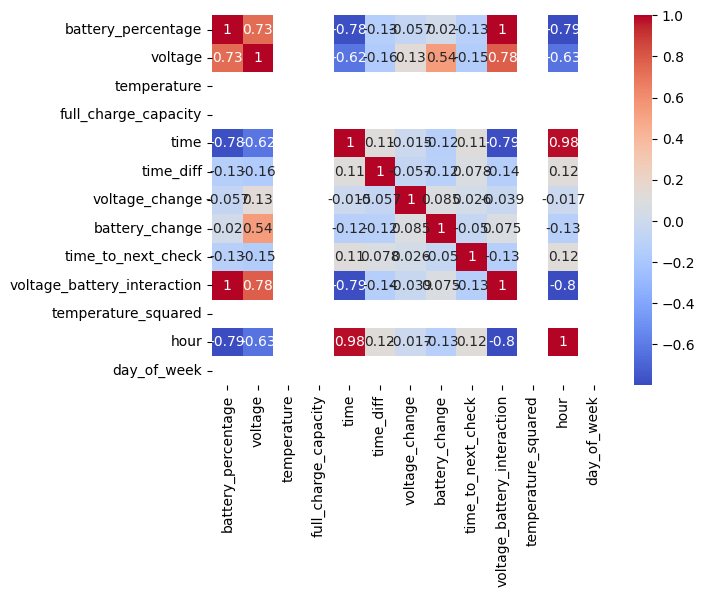

In [5]:

# Save the trained model for later use
joblib.dump(best_model, '../models/battery_check_model.pkl')

# Evaluate the model
model_score = best_model.score(X_test, y_test)
print("Model Score:", model_score)

# Cross-validation scores
cross_val_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print("Cross-Validation R^2 Scores:", cross_val_scores)

# Correlation matrix (drop non-numeric columns)
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [6]:
print(corr['time_to_next_check'])

battery_percentage            -0.128149
voltage                       -0.145136
temperature                         NaN
full_charge_capacity                NaN
time                           0.108937
time_diff                      0.078394
voltage_change                 0.025693
battery_change                -0.049880
time_to_next_check             1.000000
voltage_battery_interaction   -0.131733
temperature_squared                 NaN
hour                           0.119607
day_of_week                         NaN
Name: time_to_next_check, dtype: float64
